# メモ
- https://klog.icrr.u-tokyo.ac.jp/osl/?r=29336
- 2024/04/01と4/26で2枚のITMXの画像を撮影した
- 鏡の位置がずれているように思えるが、鏡と同時にoplev lightの位置も変わっている
- oplev lightの位置のずれと鏡の位置のずれを解析から調べる

In [1]:
def factor_px2mm(mirror_name):
    global threshold_low
    global threshold_high
    global shift_size_max
    if mirror_name == "ETMX":       
        shift_size_max=20
        return 110.0/1243.0 # 2024/04/25~ https://klog.icrr.u-tokyo.ac.jp/osl/?r=29330
    if mirror_name == "ETMY":
        shift_size_max=20
        return 110.0/1248
    if mirror_name == "ITMX":
        shift_size_max=20
        return 110.0/630.0
    if mirror_name == "ITMY":
        threshold_low=70
        threshold_high=130     
        shift_size_max=20
        return 110.0/640.0 

In [2]:
import cv2
import os
import sys
import datetime
import argparse
import numpy as np
# import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.signal import argrelmax

import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["legend.fontsize"] = 20

mpl.rcParams['axes.linewidth'] = 2

mpl.rcParams['figure.facecolor'] = "white"

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In [3]:
input1 = "/Volumes/knock_SSD/TCam/orig/2024/0401/TCam_ITMX_00111_2024_0401_174704.png"
input2 = "/Volumes/knock_SSD/TCam/orig/2024/0426/TCam_ITMX_00011_2024_0426_081020.png"
print(input1)
print(input2)

ncharactor = 20
nbin = 20

n_blur = 10
if n_blur > 0:
    flag_blur = True
else:
    flag_blur = False
#
# parameters for the analysis
#
threshold_low=70
threshold_high=130
shift_size_max=5

# TCam_ETMX_01111_2023_1016_062934.png
fname1 = os.path.basename(input1)
dirname1 = os.path.dirname(input1)
fname2 = os.path.basename(input2)
dirname2 = os.path.dirname(input2)

tmp = fname1.split("_")
mirror_name1 = tmp[1]
tmp = fname2.split("_")
mirror_name2 = tmp[1]

if mirror_name1 != mirror_name2:
    print("error: different mirror images, %s != %s" % (mirror_name1, mirror_name2))
    sys.exit(1)
px2mm = factor_px2mm(mirror_name1)
print(shift_size_max)
print(threshold_low, threshold_high)

/Volumes/knock_SSD/TCam/orig/2024/0401/TCam_ITMX_00111_2024_0401_174704.png
/Volumes/knock_SSD/TCam/orig/2024/0426/TCam_ITMX_00011_2024_0426_081020.png
20
70 130


In [4]:
fname1_head = os.path.splitext(fname1)[0]
fname2_head = os.path.splitext(fname2)[0]

fname2_head = fname2_head + "_b%d" % n_blur

img1 = cv2.imread(input1, cv2.IMREAD_UNCHANGED)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
if flag_blur:
    img1_gray = cv2.blur(img1_gray,(n_blur, n_blur))
img1 = cv2.threshold(img1_gray, threshold_low, threshold_high, cv2.THRESH_BINARY)[1]

img2 = cv2.imread(input2, cv2.IMREAD_UNCHANGED)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
if flag_blur:
    img2_gray = cv2.blur(img2_gray,(n_blur, n_blur))
img2 = cv2.threshold(img2_gray, threshold_low, threshold_high, cv2.THRESH_BINARY)[1]  

height, width = img1.shape

# plt.figure(figsize = (width/100, height/100), dpi=100)
# plt.imshow(img1, cmap = 'gray', interpolation = 'bicubic')
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.savefig("img1_orig_%s.png" % fname1_head)

# plt.figure(figsize = (width/100, height/100), dpi=100)
# plt.imshow(img2, cmap = 'gray', interpolation = 'bicubic')
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.savefig("img2_orig_%s.png" % fname2_head)

##### number of kp #####
1393 700
##### des #####
[[  0 237   1 ... 252 255   1]
 [ 64 169   1 ... 121 255   7]
 [ 33 255  15 ... 253 255  15]
 ...
 [ 97 253 137 ...   0  96  15]
 [ 64  13  10 ...   2   0  15]
 [165 247  77 ...   9 115   0]] [[224 226   3 ... 123 255  39]
 [ 64 232   1 ... 121 255  15]
 [ 64 173   0 ... 255 255   1]
 ...
 [101 237 221 ...  50 102   3]
 [ 97 253   9 ... 115 254   7]
 [ 72 237   3 ...   3  96  15]]
##### vector of des #####
(1393, 61) (700, 61)


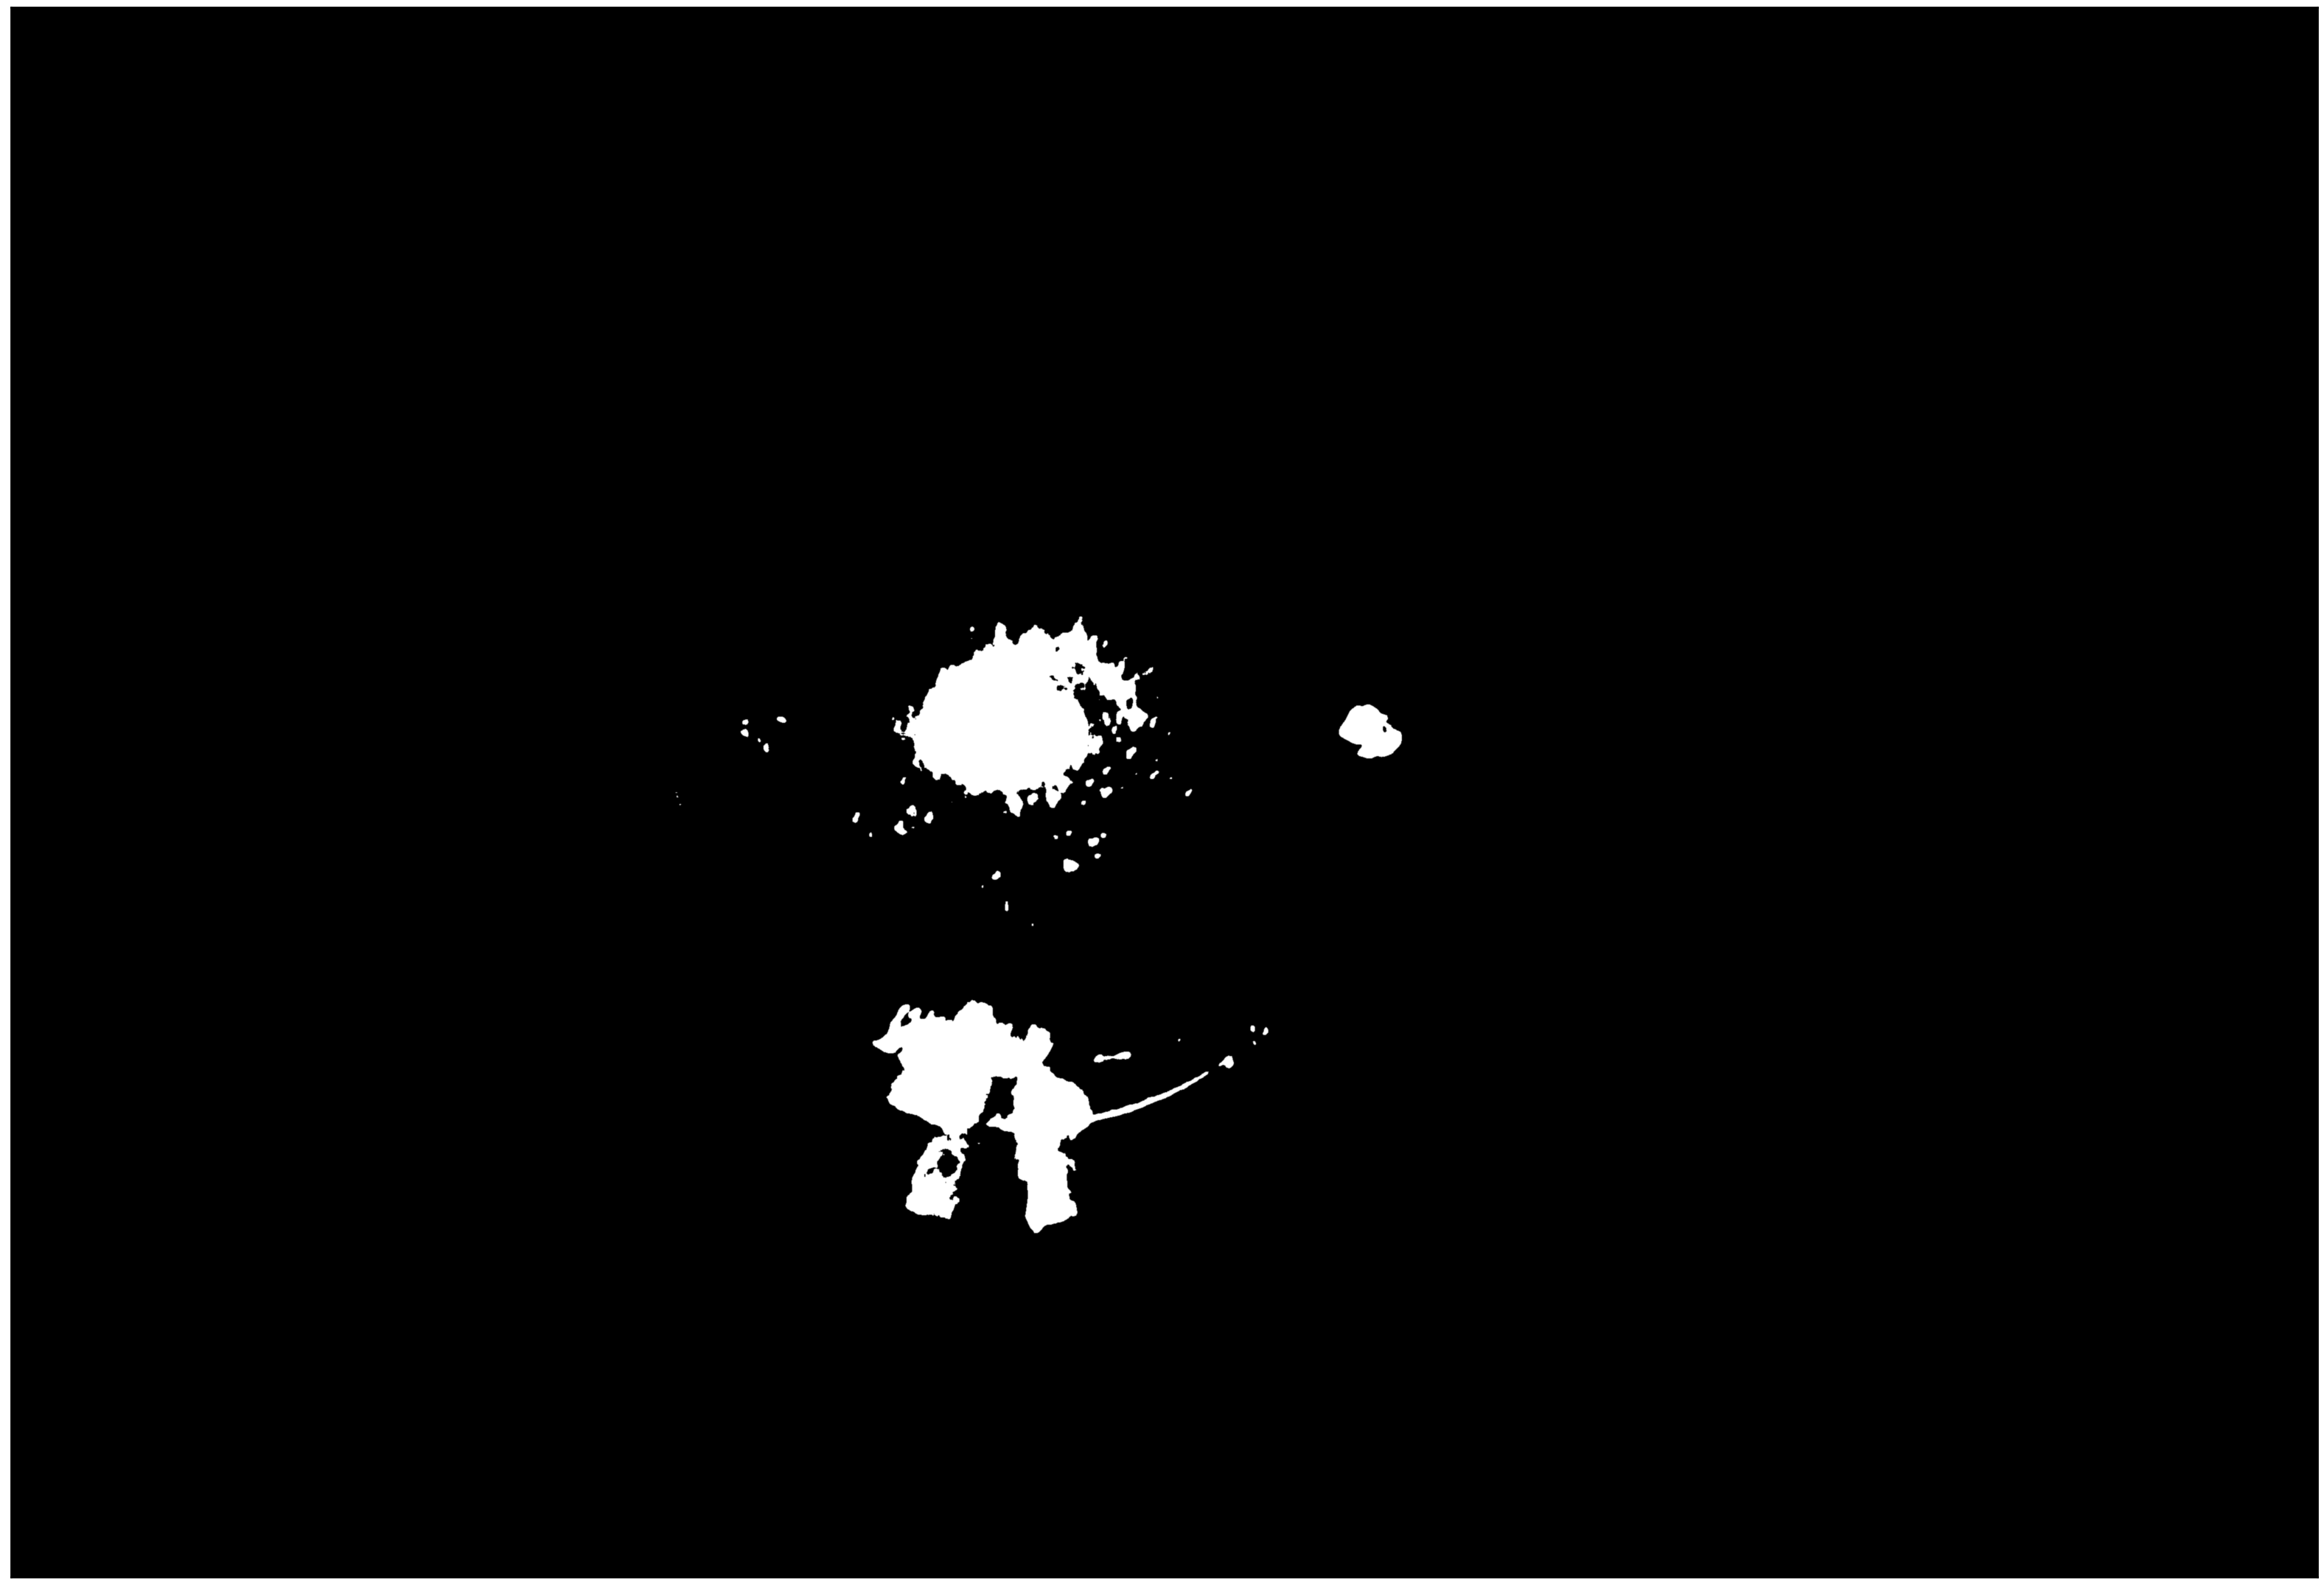

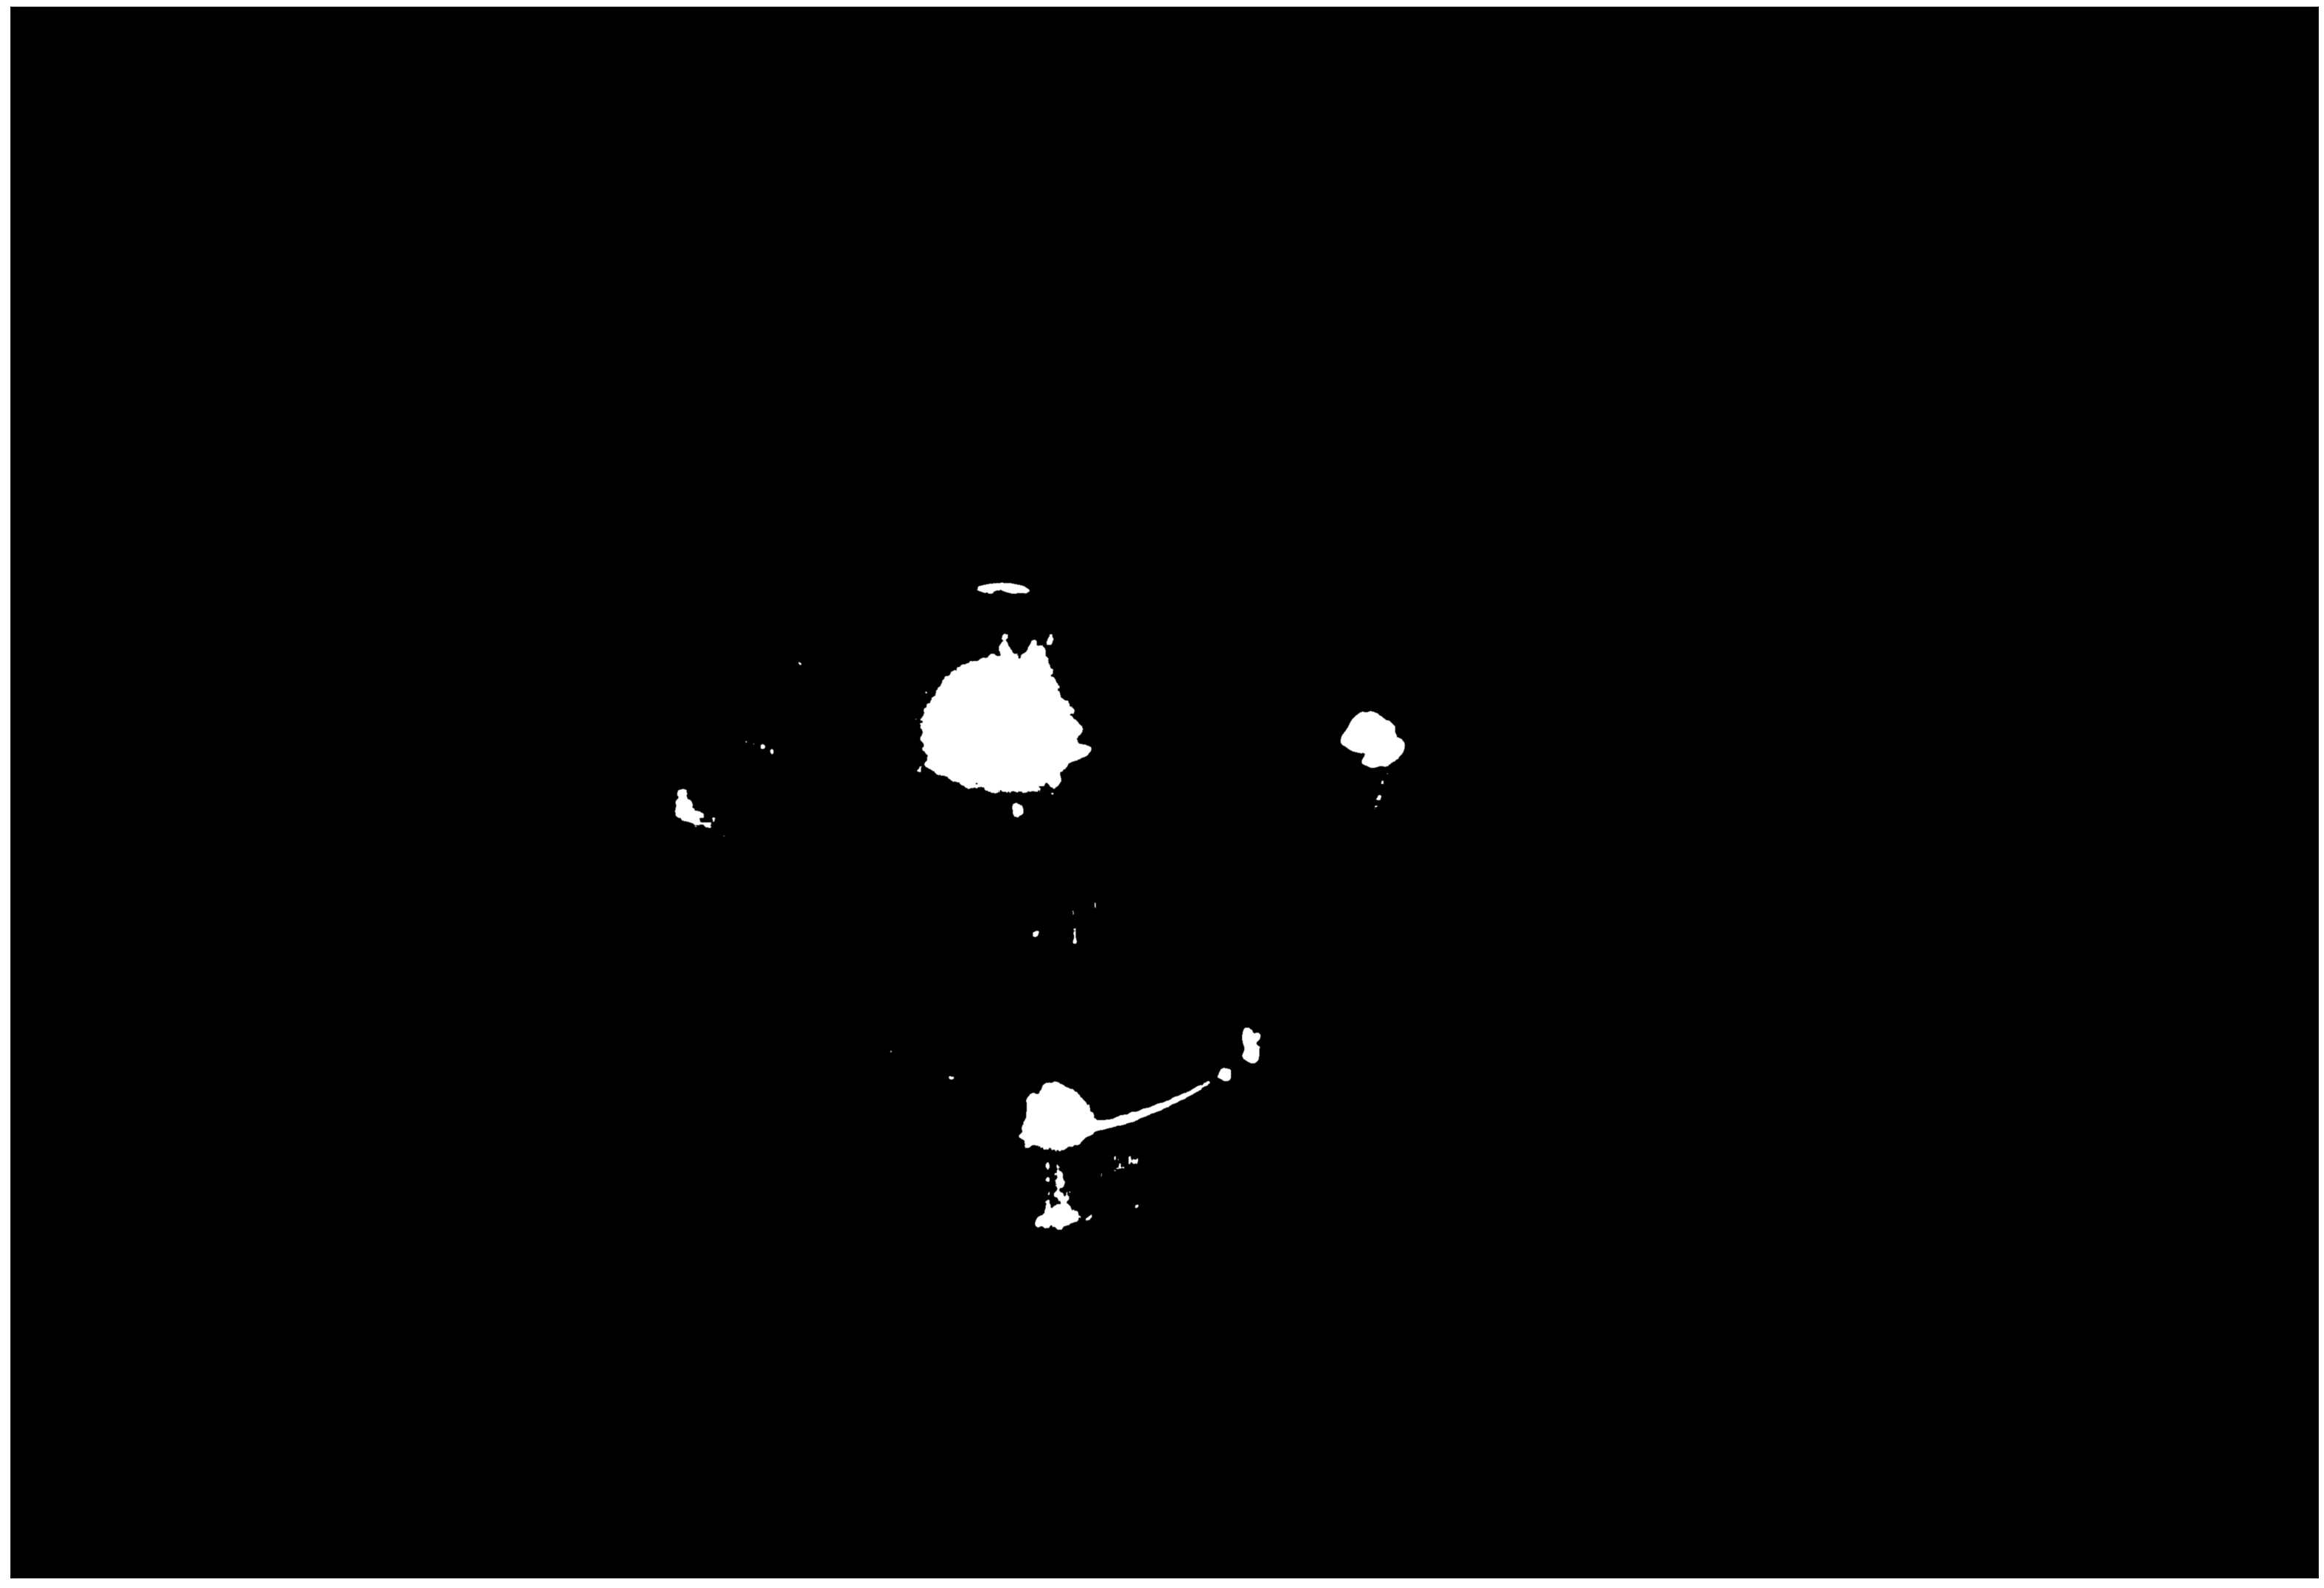

In [5]:
plt.figure(figsize = (width/100, height/100), dpi=100)
plt.imshow(img1, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.savefig("img1_gray_%s.png" % fname1_head)

plt.figure(figsize = (width/100, height/100), dpi=100)
plt.imshow(img2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.savefig("img2_gray_%s.png" % fname2_head)

akaze = cv2.AKAZE_create()
kp1, des1 = akaze.detectAndCompute(img1, None)
kp2, des2 = akaze.detectAndCompute(img2, None)

print('##### number of kp #####') # 特徴点の数
print(len(kp1), len(kp2))

print('##### des #####') # 特徴量記述子
print(des1, des2)

print('##### vector of des #####') # 特徴ベクトル
print(des1.shape, des2.shape)

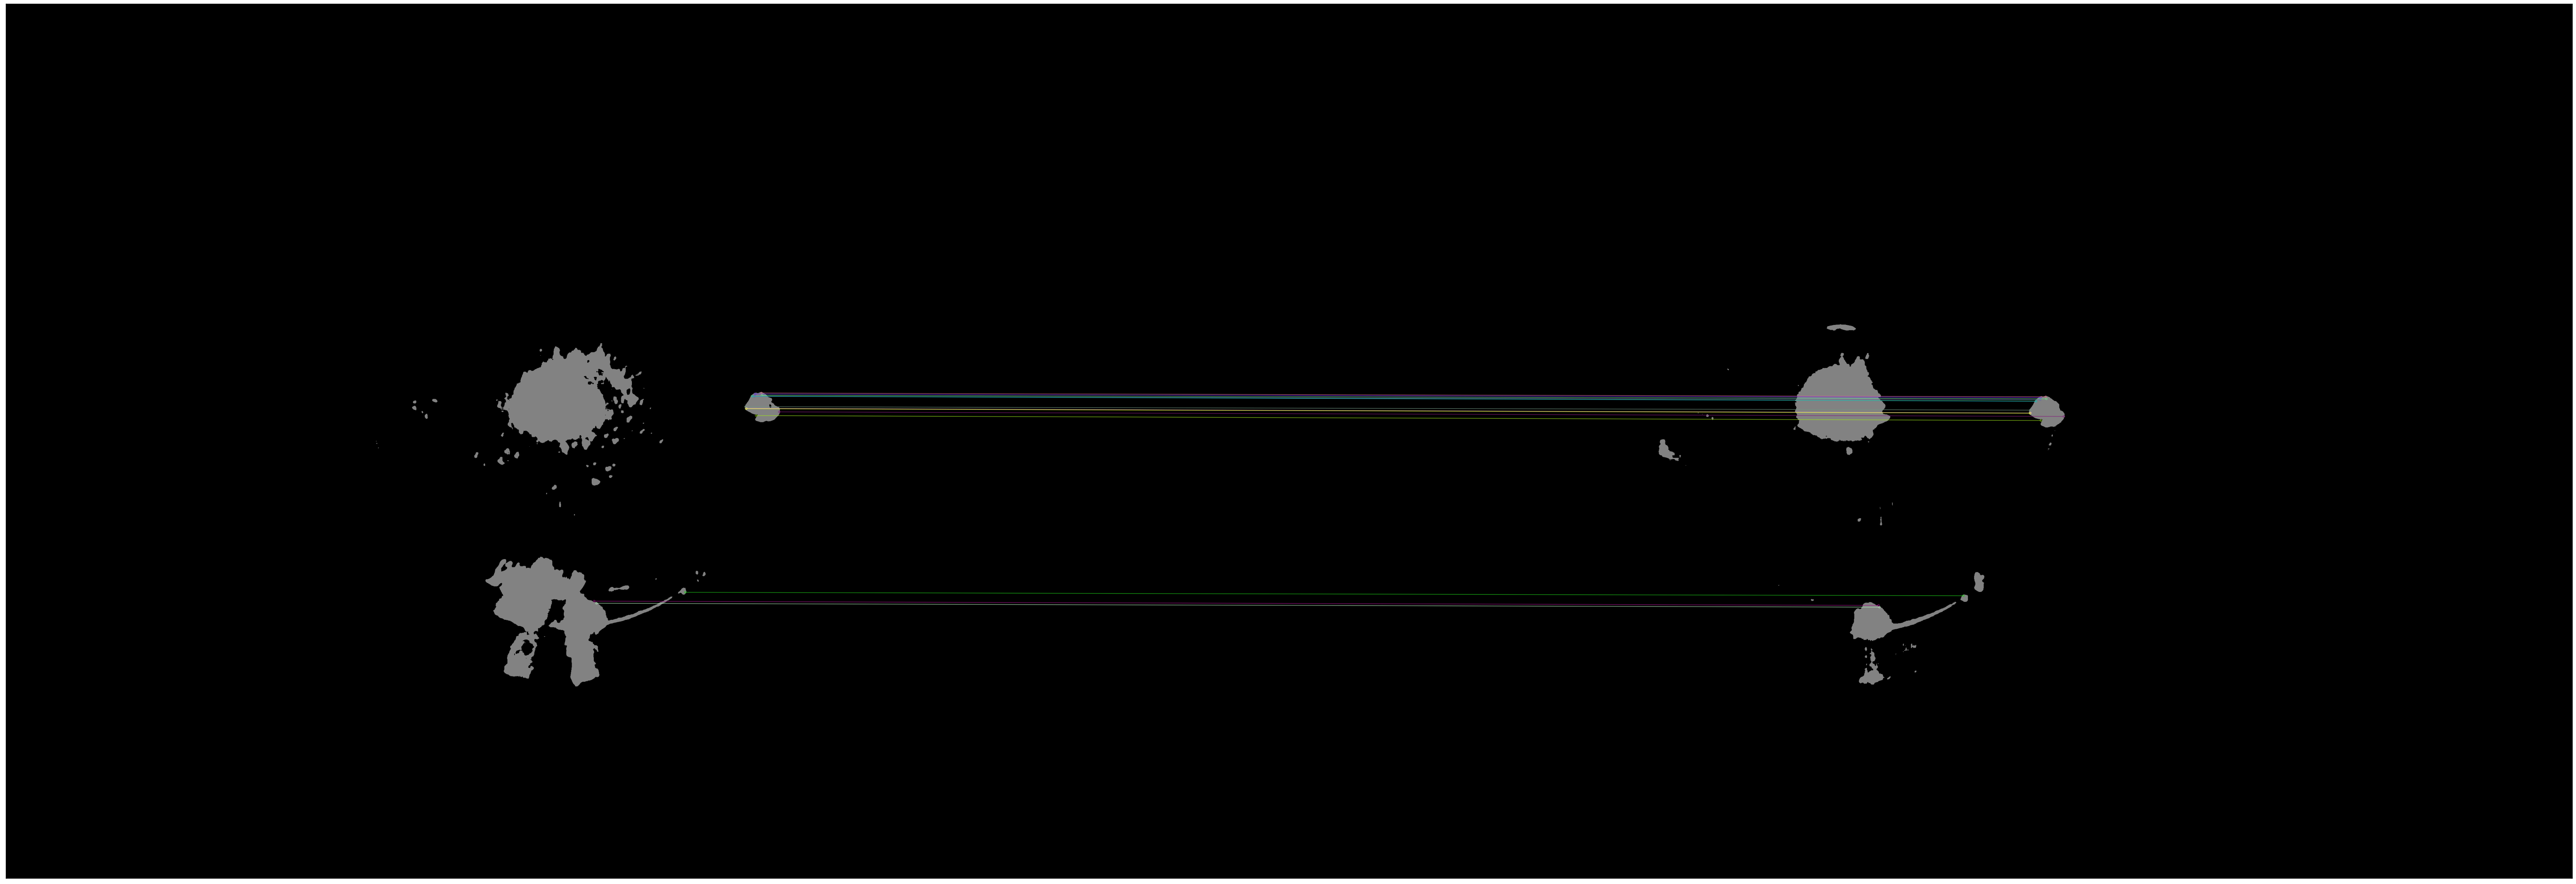

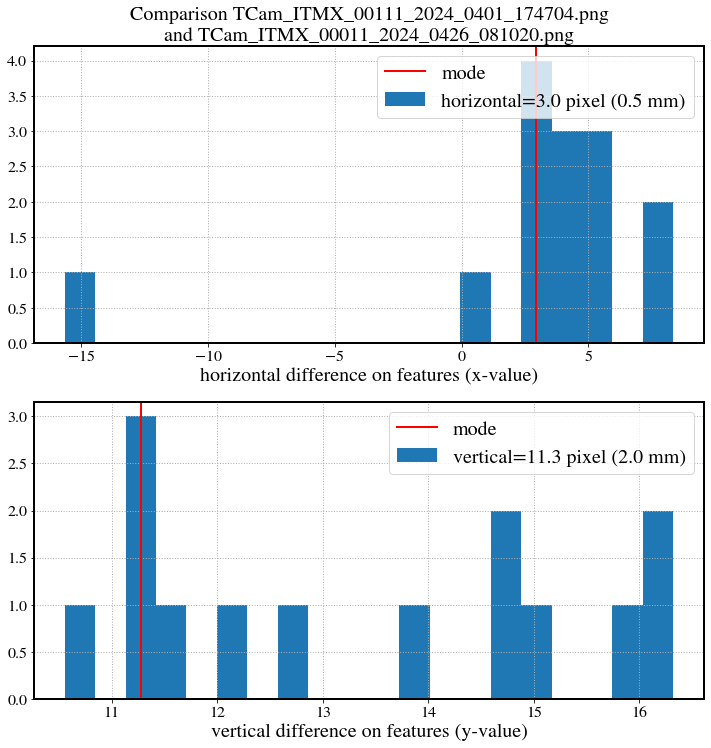

In [6]:
# マッチング
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2) # マッチした特徴点がcv2.DMatchクラスとして配列で返される

# 特徴点間のハミング距離でソート
matches = sorted(matches, key=lambda x: x.distance)

n=ncharactor
x_diff = []
y_diff = []
matches2 = []

for i in range(n):
    #print(kp1[matches[i].queryIdx].pt, kp2[matches[i].trainIdx].pt)
    # reference : https://qiita.com/komiya_____/items/c024e38959e389442dd0
    x = - (kp1[matches[i].queryIdx].pt[0] - kp2[matches[i].trainIdx].pt[0])
    y = - (kp1[matches[i].queryIdx].pt[1] - kp2[matches[i].trainIdx].pt[1])
    if abs(x) < shift_size_max and abs(y) < shift_size_max:
        x_diff.append(x)
        y_diff.append(y)
        matches2.append(matches[i])

img1_2 = cv2.drawMatches(img1, kp1, img2, kp2, matches2, None, flags=2)
plt.figure(figsize = (width*2/100, height/100), dpi=100)
plt.imshow(img1_2)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.savefig("diff_features_%s_%s.png" % (fname1_head, fname2_head))        
        
        
        
fig = plt.figure(figsize=[12, 12])

# x_diff = x_diff[~np.isnan(x_diff)]
# y_diff = y_diff[~np.isnan(y_diff)]

plt.subplot(2, 1, 1)
plt.title("Comparison %s\nand %s" % (fname1, fname2))
# data histogram
hist, bins = np.histogram(x_diff, nbin)
delta = (bins[1]-bins[0])/2
xr = np.linspace(np.min(bins)+delta,np.max(bins)-delta,len(bins)-1)
x_max = xr[np.argmax(hist)]

#plt.hist(x_diff,  bins=nbin, label="horizontal difference\nmode=%.1f pixel" % (x_max))
plt.hist(x_diff,  bins=nbin, label="horizontal=%.1f pixel (%.1f mm)" % (x_max, x_max * px2mm))
plt.axvline(x_max, label='mode',color="red", linewidth=2)
plt.legend(loc="upper right")
plt.xlabel("horizontal difference on features (x-value)")
plt.grid(linestyle='dotted', linewidth=1)

plt.subplot(2, 1, 2)
# data histogram
hist, bins = np.histogram(y_diff, nbin)
delta = (bins[1]-bins[0])/2
xr = np.linspace(np.min(bins)+delta,np.max(bins)-delta,len(bins)-1)
x_max = xr[np.argmax(hist)]

#plt.hist(y_diff,  bins=nbin, label="vertical difference\nmode=%.1f pixel" % (x_max))
plt.hist(y_diff,  bins=nbin, label="vertical=%.1f pixel (%.1f mm)" % (x_max, x_max * px2mm))
plt.axvline(x_max, label='mode',color="red", linewidth=2)
plt.legend(loc="upper right")
plt.xlabel("vertical difference on features (y-value)")
plt.grid(linestyle='dotted', linewidth=1)


fig.savefig("hist_%s_%s.png" % (fname1_head, fname2_head))


In [7]:
# # マッチング
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# matches = bf.match(des1, des2) # マッチした特徴点がcv2.DMatchクラスとして配列で返される

# # 特徴点間のハミング距離でソート
# matches = sorted(matches, key=lambda x: x.distance)

# # 2画像間のマッチング結果画像を作成
# if ncharactor >= 40:
#     img1_2 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:40], None, flags=2)
# else:
#     img1_2 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:ncharactor], None, flags=2)
# plt.figure(figsize = (width*2/100, height/100), dpi=100)
# plt.imshow(img1_2)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.savefig("diff_features_%s_%s.png" % (fname1_head, fname2_head))

# n=ncharactor
# x_diff = np.zeros(n)
# y_diff = np.zeros(n)
# for i in range(n):
#     #print(kp1[matches[i].queryIdx].pt, kp2[matches[i].trainIdx].pt)
#     # reference : https://qiita.com/komiya_____/items/c024e38959e389442dd0
#     print(kp1[matches[i].queryIdx].pt[0], kp2[matches[i].trainIdx].pt[0])
#     print(kp1[matches[i].queryIdx].pt[1], kp2[matches[i].trainIdx].pt[1])
#     x = - (kp1[matches[i].queryIdx].pt[0] - kp2[matches[i].trainIdx].pt[0])
#     if abs(x) > shift_size_max:
#         x_diff[i] = None
#     else:
#         x_diff[i] = x

#     x = - (kp1[matches[i].queryIdx].pt[1] - kp2[matches[i].trainIdx].pt[1])
#     if abs(x) > shift_size_max:
#         y_diff[i] = None
#     else:
#         y_diff[i] = x
    
# fig = plt.figure(figsize=[12, 12])

# x_diff = x_diff[~np.isnan(x_diff)]
# y_diff = y_diff[~np.isnan(y_diff)]

# plt.subplot(2, 1, 1)
# plt.title("Comparison %s\nand %s" % (fname1, fname2))
# # data histogram
# hist, bins = np.histogram(x_diff, nbin)
# delta = (bins[1]-bins[0])/2
# xr = np.linspace(np.min(bins)+delta,np.max(bins)-delta,len(bins)-1)
# x_max = xr[np.argmax(hist)]

# #plt.hist(x_diff,  bins=nbin, label="horizontal difference\nmode=%.1f pixel" % (x_max))
# plt.hist(x_diff,  bins=nbin, label="horizontal=%.1f pixel (%.1f mm)" % (x_max, x_max * px2mm))
# plt.axvline(x_max, label='mode',color="red", linewidth=2)
# plt.legend(loc="upper right")
# plt.xlabel("horizontal difference on features (x-value)")
# plt.grid(linestyle='dotted', linewidth=1)

# plt.subplot(2, 1, 2)
# # data histogram
# hist, bins = np.histogram(y_diff, nbin)
# delta = (bins[1]-bins[0])/2
# xr = np.linspace(np.min(bins)+delta,np.max(bins)-delta,len(bins)-1)
# x_max = xr[np.argmax(hist)]

# #plt.hist(y_diff,  bins=nbin, label="vertical difference\nmode=%.1f pixel" % (x_max))
# plt.hist(y_diff,  bins=nbin, label="vertical=%.1f pixel (%.1f mm)" % (x_max, x_max * px2mm))
# plt.axvline(x_max, label='mode',color="red", linewidth=2)
# plt.legend(loc="upper right")
# plt.xlabel("vertical difference on features (y-value)")
# plt.grid(linestyle='dotted', linewidth=1)


# fig.savefig("hist_%s_%s.png" % (fname1_head, fname2_head))
